In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching_with_domain"
except:
    pass

import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation with closed-form formula given by Borodin

In [2]:
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
\begin{align*}
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
& \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
\\
& - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
\end{align*}
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [4]:
problem_name = "heat_equation"
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x, coordinate=0):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, coordinate=0, lower_bound=-10, upper_bound=10, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi = 0., -2, 2

Patch 0: generation of u samples take 3.9784493446350098 seconds.
Patch  0: epoch    0 with loss 1.10E+01
Patch  0: epoch  500 with loss 1.87E-05
Patch  0: epoch 1000 with loss 1.77E-05
Patch  0: epoch 1500 with loss 1.69E-05
Patch  0: epoch 2000 with loss 1.63E-05
Patch  0: epoch 2500 with loss 1.58E-05
Patch  0: epoch 3000 with loss 5.41E-05
Patch  0: epoch 3500 with loss 4.72E-04
Patch  0: epoch 4000 with loss 1.66E-05
Patch  0: epoch 4500 with loss 3.49E-05
Patch  0: epoch 4999 with loss 1.72E-05
Patch 0: training of u with 5000 epochs take 45.48011088371277 seconds.
Patch 1: generation of u samples take 4.793854713439941 seconds.
Patch  1: epoch    0 with loss 2.11E+00
Patch  1: epoch  500 with loss 7.23E-06
Patch  1: epoch 1000 with loss 4.92E-06
Patch  1: epoch 1500 with loss 4.87E-06
Patch  1: epoch 2000 with loss 4.38E-06
Patch  1: epoch 2500 with loss 6.04E-06
Patch  1: epoch 3000 with loss 5.20E-06
Patch  1: epoch 3500 with loss 4.05E-06
Patch  1: epoch 4000 with loss 5.47E-

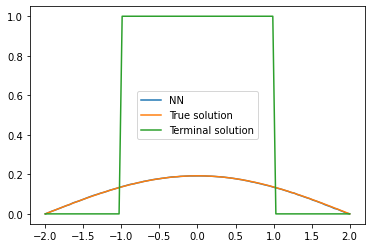

In [4]:
patches = 5
T = patches * 1.0

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_fun=partial(exact_example, lower_bound=x_lo, upper_bound=x_hi, with_bound=True))

## Example 2: Kuramoto equation 1

In [27]:
problem_name = "kuramoto_equation_1"
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x, coordinate=0):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T, coordinate=0, order=(0, 0)):
    theta = -.5 * x[0] - (T - t)
    if order[1] == 0:
        return (
            15
            + 15 * np.tanh(theta)
            - 15 * (np.tanh(theta))**2
            - 15 * (np.tanh(theta))**3
        )
    elif order[1] == 1:
        return -.5 / (np.cosh(theta))**2 * (
            15
            - 30 * np.tanh(theta)
            - 45 * (np.tanh(theta))**2
        )
    elif order[1] == 2:
        return (
            - .5 / (np.cosh(theta))**4 * (
                15 + 45 * np.tanh(theta)
            )
            - .5 * np.tanh(theta) / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 3:
        return (
            11.25 / (np.cosh(theta))**6
            + .25 / (np.cosh(theta))**4 * (
                15 - 120 * np.tanh(theta) - 315 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**2 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 4:
        return (
            1 / (np.cosh(theta))**6 * (
                15 + 112.5 * np.tanh(theta)
            )
            + .5 * np.tanh(theta) / (np.cosh(theta))**4 * (
                30 - 165 * np.tanh(theta) - 405 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**3 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )

t_lo, x_lo, x_hi = 0., -10, 10

### patches = 5, T = 0.5

Patch 0: generation of u samples take 81.90786957740784 seconds.
Patch  0: epoch    0 with loss 4.43E+01
Patch  0: epoch  500 with loss 1.95E-02
Patch  0: epoch 1000 with loss 1.82E-02
Patch  0: epoch 1500 with loss 1.87E-02
Patch  0: epoch 2000 with loss 2.10E-02
Patch  0: epoch 2500 with loss 1.81E-02
Patch  0: epoch 3000 with loss 1.86E-02
Patch  0: epoch 3500 with loss 1.81E-02
Patch  0: epoch 4000 with loss 1.81E-02
Patch  0: epoch 4500 with loss 1.81E-02
Patch  0: epoch 4999 with loss 1.80E-02
Patch 0: training of u with 5000 epochs take 46.00157713890076 seconds.
Patch 1: generation of u samples take 325.0890386104584 seconds.
Patch  1: epoch    0 with loss 4.16E+01
Patch  1: epoch  500 with loss 1.07E-01
Patch  1: epoch 1000 with loss 1.05E-01
Patch  1: epoch 1500 with loss 1.04E-01
Patch  1: epoch 2000 with loss 1.02E-01
Patch  1: epoch 2500 with loss 1.01E-01
Patch  1: epoch 3000 with loss 1.02E-01
Patch  1: epoch 3500 with loss 1.01E-01
Patch  1: epoch 4000 with loss 1.04E-0

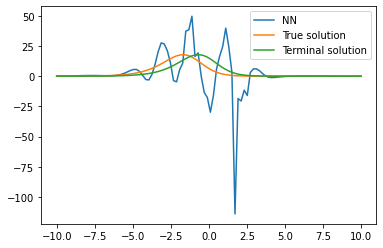

In [7]:
patches = 5
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=100,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_example)

### patches = 2, T = .2

The model is saved to logs/20220525-091749-kuramoto_equation_1-T0.2-nu2


Patch 0: generation of u samples take 85.35497331619263 seconds.
Patch  0: epoch    0 with loss 5.04E+01
Patch  0: epoch  500 with loss 6.81E-02
Patch  0: epoch 1000 with loss 1.22E-02
Patch  0: epoch 1500 with loss 1.22E-02
Patch  0: epoch 2000 with loss 1.34E-02
Patch  0: epoch 2500 with loss 1.24E-02
Patch  0: epoch 3000 with loss 1.23E-02
Patch  0: epoch 3500 with loss 1.23E-02
Patch  0: epoch 4000 with loss 1.23E-02
Patch  0: epoch 4500 with loss 1.22E-02
Patch  0: epoch 4999 with loss 1.22E-02
Patch 0: training of u with 5000 epochs take 49.01965641975403 seconds.
Patch 1: generation of u samples take 314.9348282814026 seconds.
Patch  1: epoch    0 with loss 3.78E+01
Patch  1: epoch  500 with loss 1.28E-02
Patch  1: epoch 1000 with loss 1.19E-02
Patch  1: epoch 1500 with loss 1.12E-02
Patch  1: epoch 2000 with loss 2.73E-02
Patch  1: epoch 2500 with loss 1.10E-02
Patch  1: epoch 3000 with loss 1.04E-02
Patch  1: epoch 3500 with loss 9.95E-03
Patch  1: epoch 4000 with loss 1.00E-0

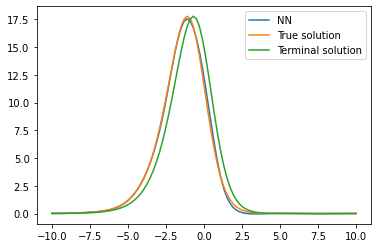

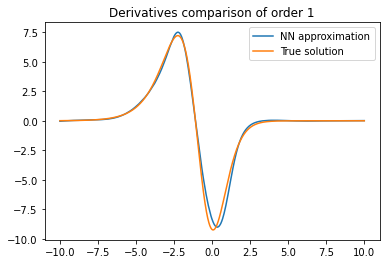

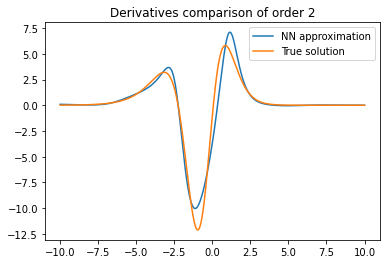

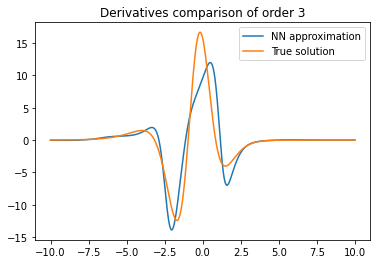

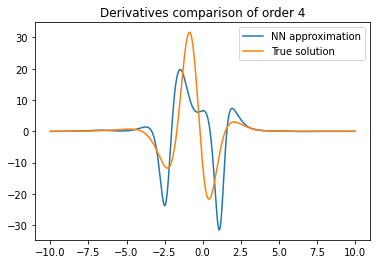

In [28]:
patches = 2
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
model.compare_with_exact(exact_example)

grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

# plot derivatives of all NN solutions for comparison
for order in ((0, 1), (0, 2), (0, 3), (0, 4)):
    true = exact_example(t_lo, grid_d_dim, T, order=order)
    x = torch.tensor(grid_d_dim_with_t.astype(np.float32), device=model.device, requires_grad=True)
    y =  model(x.T, patch=patches-1)
    deriv = model.nth_derivatives(order, y, x)
    plt.plot(grid, deriv.detach().cpu(), label="NN approximation")
    plt.plot(grid, true, label="True solution")
    plt.title(f"Derivatives comparison of order {order[1]}")
    plt.legend()
    plt.show()

## Example 3: Kuramoto equation 5

In [10]:
problem_name = "kuramoto_equation_5"
alpha, gamma = 1, 1

# function definition
deriv_map = np.array([0, 1, 4]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> forth deriv
    """
    return y[0] * y[1] + gamma * y[2]

def phi_example(x, coordinate=0):
    return torch.exp(-x[0]**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

Patch 0: generation of u samples take 106.74583506584167 seconds.
Patch  0: epoch    0 with loss 1.06E+01
Patch  0: epoch  500 with loss 7.76E-02
Patch  0: epoch 1000 with loss 5.29E-02
Patch  0: epoch 1500 with loss 3.23E-02
Patch  0: epoch 2000 with loss 3.11E-02
Patch  0: epoch 2500 with loss 3.09E-02
Patch  0: epoch 3000 with loss 3.08E-02
Patch  0: epoch 3500 with loss 3.11E-02
Patch  0: epoch 4000 with loss 3.08E-02
Patch  0: epoch 4500 with loss 3.07E-02
Patch  0: epoch 4999 with loss 3.07E-02
Patch 0: training of u with 5000 epochs take 49.75723719596863 seconds.
Patch 1: generation of u samples take 533.4041931629181 seconds.
Patch  1: epoch    0 with loss 4.22E+00
Patch  1: epoch  500 with loss 2.17E+00
Patch  1: epoch 1000 with loss 2.12E+00
Patch  1: epoch 1500 with loss 2.10E+00
Patch  1: epoch 2000 with loss 2.10E+00
Patch  1: epoch 2500 with loss 2.11E+00
Patch  1: epoch 3000 with loss 2.10E+00
Patch  1: epoch 3500 with loss 2.10E+00
Patch  1: epoch 4000 with loss 2.10E+

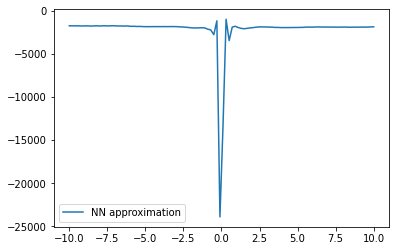

In [11]:
patches = 5
T = patches * .1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(conditional_probability_to_survive, lower_bound=x_lo, upper_bound=x_hi),
    is_x_inside=partial(is_x_inside, lower_bound=x_lo, upper_bound=x_hi),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
    overtrain_rate=0.,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.legend()
plt.show()

## Example 4: Navier-Stokes equation

We consider the 2D Navier-Stokes equation inside the square $[0, 1]^2$. For this, we let the wall be the horizontal lines $y = 0$ and $y = 1$, and let the inlet at $x = 0$ flowing to the direction $x = 1$.

It can be checked that the velocity flow $u(t, x, y) = (y(1-y), 0)$ with the pressure $p(t, x, y) = 2\nu(1 -x)$ satisfies the Navier-Stokes equation
$$
  \partial_t u(t,x) + \nu \Delta u(t,x)
  =
  \nabla p(t,x)
 + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$.

In [3]:
problem_name = "navier_stokes_2d_with_boundary"
nu = .2

t_lo, x_lo, x_hi = 0., 0, 1

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -(x[1] - x_lo) * (x[1] - x_hi)
    else:
        return torch.zeros_like(x[0])

def p_example(x):
    return 2 * nu * (1 - x[0]).unsqueeze(dim=-1)

def plot_wall(model, nb_points):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(model.x_lo, model.x_hi + delta)
    plt.ylim(model.x_lo, model.x_hi)
    wall = np.linspace(model.x_lo, model.x_hi + delta, nb_points)
    wall_lo = model.x_lo * np.ones_like(wall)
    wall_hi = model.x_hi * np.ones_like(wall)
    plt.plot(wall, wall_lo, color="black",linewidth=lw)
    plt.plot(wall, wall_hi, color="black",linewidth=lw)

def plot_fluid(model, nb_points=20):
    x1, x2 = np.meshgrid(
        np.linspace(model.x_lo, model.x_hi, nb_points),
        np.linspace(model.x_lo, model.x_hi, nb_points)
    )
    x_tensor = torch.tensor(
        np.stack((np.zeros_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype()
    ).reshape(3, -1)
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    u = (
        model(x_tensor.T, patch=0).T.detach().cpu()
    )
    u1_term = model.phi_fun(x_tensor[1:], 0).cpu()
    u2_term = model.phi_fun(x_tensor[1:], 1).cpu()
    f = plt.figure()
    plot_wall(model, nb_points)
    plt.quiver(x1, x2, u1_term, u2_term)
    plt.title("Fluid flow at terminal time")
    f.savefig(f"{model.working_dir}/plot/terminal_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    f = plt.figure()
    plot_wall(model, nb_points)
    plt.quiver(x1, x2, u[0], u[1])
    plt.title("Fluid flow at t = 0")
    f.savefig(f"{model.working_dir}/plot/t0_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

def calculate_error(model, nb_points=20):
    x1, x2 = np.meshgrid(
        np.linspace(model.x_lo, model.x_hi, nb_points),
        np.linspace(model.x_lo, model.x_hi, nb_points)
    )
    x_tensor = torch.tensor(
        np.stack((np.zeros_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype()
    ).reshape(3, -1)
    u = (
        model(x_tensor.T, patch=0).T.detach().cpu()
    )
    u1_term = model.phi_fun(x_tensor[1:], 0).cpu()
    u2_term = model.phi_fun(x_tensor[1:], 1).cpu()
    return torch.nn.MSELoss()(u, torch.stack((u1_term, u2_term))).item()

The model is saved to logs/20220526-100913-navier_stokes_2d_with_boundary-T1-nu0.2


Patch 0: generation of u samples take 308.3933804035187 seconds.
Patch  0: epoch    0 with loss 7.22E+00
Patch  0: epoch  500 with loss 7.24E-03
Patch  0: epoch 1000 with loss 4.64E-03
Patch  0: epoch 1500 with loss 1.31E-03
Patch  0: epoch 2000 with loss 2.51E-03
Patch  0: epoch 2500 with loss 1.03E-03
Patch  0: epoch 3000 with loss 8.01E-04
Patch  0: epoch 3500 with loss 2.45E-03
Patch  0: epoch 4000 with loss 6.16E-04
Patch  0: epoch 4500 with loss 1.07E-03
Patch  0: epoch 5000 with loss 5.40E-04
Patch  0: epoch 5500 with loss 8.29E-04
Patch  0: epoch 6000 with loss 1.73E-02
Patch  0: epoch 6500 with loss 9.72E-04
Patch  0: epoch 7000 with loss 2.40E-03
Patch  0: epoch 7500 with loss 6.53E-04
Patch  0: epoch 8000 with loss 6.81E-04
Patch  0: epoch 8500 with loss 8.17E-04
Patch  0: epoch 9000 with loss 4.33E-04
Patch  0: epoch 9500 with loss 7.64E-04
Patch  0: epoch 9999 with loss 6.97E-04
Patch 0: training of u with 10000 epochs take 206.7294261455536 seconds.


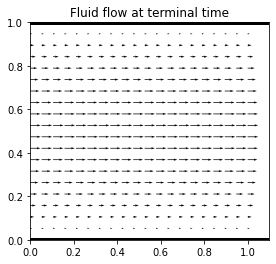

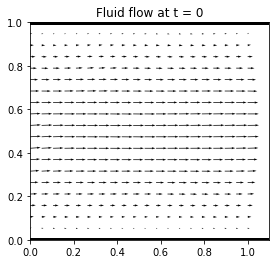

The mean squared error of the model is 2.21E-04.


In [4]:
patches = 1
T = patches * 1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun=p_example,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
)
print(f"The model is saved to {model.working_dir}")
model.train_and_eval(debug_mode=False)
plot_fluid(model)
print(f"The mean squared error of the model is {calculate_error(model):.2E}.")

## Example 5: Navier-Stokes equation

In [3]:
problem_name = "navier_stokes_2d_with_boundary"
alpha_for_f = 2

def f(x):
    return (1-x)**alpha_for_f * x**alpha_for_f

def fprime(x):
    return alpha_for_f * (1-x)**(alpha_for_f-1) * x**(1-alpha_for_f) * (1-2*x)

def g(x):
    return 1 + x**2

def gprime(x):
    return 2 * x

t_lo, x_lo, x_hi = 0., 0, 1

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_points):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(model.x_lo, model.x_hi + delta)
    plt.ylim(model.x_lo, model.x_hi)
    wall = np.linspace(model.x_lo, model.x_hi + delta, nb_points)
    wall_lo = model.x_lo * np.ones_like(wall)
    wall_hi = model.x_hi * np.ones_like(wall)
    plt.plot(wall, wall_lo, color="black",linewidth=lw)
    plt.plot(wall, wall_hi, color="black",linewidth=lw)

def plot_fluid(model, nb_points=20):
    x1, x2 = np.meshgrid(
        np.linspace(model.x_lo, model.x_hi, nb_points),
        np.linspace(model.x_lo, model.x_hi, nb_points)
    )
    x_tensor = torch.tensor(
        np.stack((np.zeros_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype()
    ).reshape(3, -1)
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    u = (
        model(x_tensor.T, patch=0).T.detach().cpu()
    )
    u1_term = model.phi_fun(x_tensor[1:], 0).cpu()
    u2_term = model.phi_fun(x_tensor[1:], 1).cpu()
    f = plt.figure()
    plot_wall(model, nb_points)
    plt.quiver(x1, x2, u1_term, u2_term)
    plt.title("Fluid flow at terminal time")
    f.savefig(f"{model.working_dir}/plot/terminal_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    f = plt.figure()
    plot_wall(model, nb_points)
    plt.quiver(x1, x2, u[0], u[1])
    plt.title("Fluid flow at t = 0")
    f.savefig(f"{model.working_dir}/plot/t0_flow.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

### nu = .2, T = 1

Logs are saved in logs/20220530-162010-navier_stokes_2d_with_boundary-T1-nu0.2
Patch 0: generation of p samples take 119.1671450138092 seconds.
Patch  0: epoch    0 with loss 5.51E+00
Patch  0: epoch  500 with loss 1.21E-02
Patch  0: epoch 1000 with loss 4.48E-02
Patch  0: epoch 1500 with loss 4.48E-02
Patch  0: epoch 2000 with loss 6.08E-03
Patch  0: epoch 2500 with loss 3.59E-03
Patch  0: epoch 3000 with loss 3.00E-03
Patch  0: epoch 3500 with loss 2.57E-03
Patch  0: epoch 4000 with loss 6.49E-03
Patch  0: epoch 4500 with loss 4.68E-03
Patch  0: epoch 5000 with loss 3.92E-02
Patch  0: epoch 5500 with loss 5.85E-03
Patch  0: epoch 6000 with loss 6.60E-03
Patch  0: epoch 6500 with loss 1.37E-02
Patch  0: epoch 7000 with loss 2.24E-02
Patch  0: epoch 7500 with loss 1.07E-01
Patch  0: epoch 8000 with loss 3.38E-03
Patch  0: epoch 8500 with loss 2.39E-03
Patch  0: epoch 9000 with loss 2.45E-03
Patch  0: epoch 9500 with loss 3.54E-03
Patch  0: epoch 9999 with loss 1.50E-03
Patch0: pre-trai

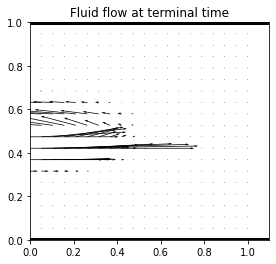

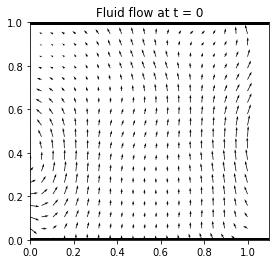

In [5]:
nu = .2
patches = 1
T = patches * 1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
)
model.train_and_eval(debug_mode=False)
plot_fluid(model)

### nu = 2, T = .1

Patch 0: generation of u samples take 508.03032064437866 seconds.
Patch  0: epoch    0 with loss 2.53E-03
Patch  0: epoch  500 with loss 4.55E-04
Patch  0: epoch 1000 with loss 1.28E-03
Patch  0: epoch 1500 with loss 1.45E-04
Patch  0: epoch 2000 with loss 6.45E-04
Patch  0: epoch 2500 with loss 1.39E-03
Patch  0: epoch 3000 with loss 2.43E-04
Patch  0: epoch 3500 with loss 6.89E-04
Patch  0: epoch 4000 with loss 3.16E-04
Patch  0: epoch 4500 with loss 3.76E-02
Patch  0: epoch 5000 with loss 7.62E-04
Patch  0: epoch 5500 with loss 1.26E-04
Patch  0: epoch 6000 with loss 2.52E-04
Patch  0: epoch 6500 with loss 2.16E-04
Patch  0: epoch 7000 with loss 5.39E-04
Patch  0: epoch 7500 with loss 9.23E-05
Patch  0: epoch 8000 with loss 7.57E-05
Patch  0: epoch 8500 with loss 8.27E-05
Patch  0: epoch 9000 with loss 1.19E-04
Patch  0: epoch 9500 with loss 2.40E-04
Patch  0: epoch 9999 with loss 1.44E-04
Patch 0: training of u with 10000 epochs take 224.12065887451172 seconds.


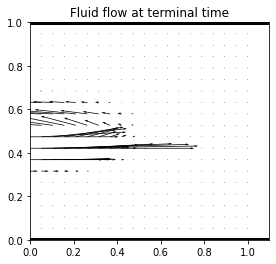

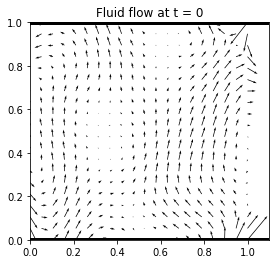

In [4]:
nu = 2
patches = 1
T = patches * .1
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220530-162010-navier_stokes_2d_with_boundary-T1-nu0.2",
)
model.train_and_eval(debug_mode=False)
plot_fluid(model)

### nu = 2, T = .01

Logs are saved in logs/20220530-183446-navier_stokes_2d_with_boundary-T0.01-nu2
Patch 0: generation of u samples take 595.86003947258 seconds.
Patch  0: epoch    0 with loss 2.50E-03
Patch  0: epoch  500 with loss 2.72E-03
Patch  0: epoch 1000 with loss 1.19E-04
Patch  0: epoch 1500 with loss 5.14E-03
Patch  0: epoch 2000 with loss 3.66E-03
Patch  0: epoch 2500 with loss 5.60E-04
Patch  0: epoch 3000 with loss 2.51E-04
Patch  0: epoch 3500 with loss 1.48E-04
Patch  0: epoch 4000 with loss 7.39E-04
Patch  0: epoch 4500 with loss 8.80E-05
Patch  0: epoch 5000 with loss 1.15E-04
Patch  0: epoch 5500 with loss 1.69E-04
Patch  0: epoch 6000 with loss 4.25E-05
Patch  0: epoch 6500 with loss 1.16E-03
Patch  0: epoch 7000 with loss 1.01E-03
Patch  0: epoch 7500 with loss 1.02E-04
Patch  0: epoch 8000 with loss 1.24E-04
Patch  0: epoch 8500 with loss 4.22E-05
Patch  0: epoch 9000 with loss 6.49E-05
Patch  0: epoch 9500 with loss 1.11E-03
Patch  0: epoch 9999 with loss 7.83E-05
Patch 0: training

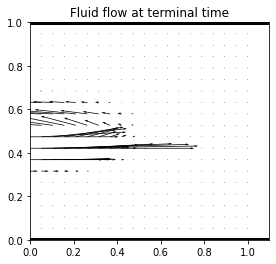

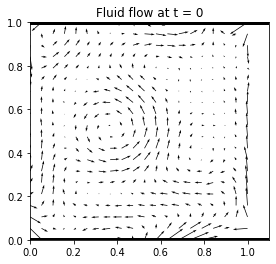

In [5]:
nu = 2
patches = 1
T = patches * .01
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220530-162010-navier_stokes_2d_with_boundary-T1-nu0.2",
)
model.train_and_eval(debug_mode=False)
plot_fluid(model)

### nu = 2, T = .005

Logs are saved in logs/20220530-185242-navier_stokes_2d_with_boundary-T0.005-nu2
Patch 0: generation of u samples take 613.4476382732391 seconds.
Patch  0: epoch    0 with loss 2.57E-03
Patch  0: epoch  500 with loss 1.19E-01
Patch  0: epoch 1000 with loss 2.03E-04
Patch  0: epoch 1500 with loss 5.99E-04
Patch  0: epoch 2000 with loss 2.30E-03
Patch  0: epoch 2500 with loss 2.44E-04
Patch  0: epoch 3000 with loss 4.83E-04
Patch  0: epoch 3500 with loss 7.35E-04
Patch  0: epoch 4000 with loss 3.55E-04
Patch  0: epoch 4500 with loss 7.10E-05
Patch  0: epoch 5000 with loss 2.44E-04
Patch  0: epoch 5500 with loss 6.13E-05
Patch  0: epoch 6000 with loss 2.62E-04
Patch  0: epoch 6500 with loss 6.46E-05
Patch  0: epoch 7000 with loss 4.14E-05
Patch  0: epoch 7500 with loss 2.89E-05
Patch  0: epoch 8000 with loss 2.36E-04
Patch  0: epoch 8500 with loss 4.06E-05
Patch  0: epoch 9000 with loss 3.78E-05
Patch  0: epoch 9500 with loss 8.61E-04
Patch  0: epoch 9999 with loss 2.99E-04
Patch 0: train

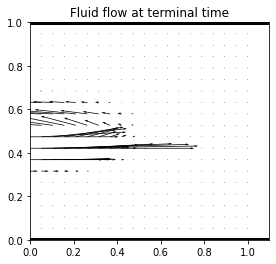

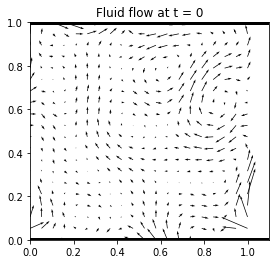

In [6]:
nu = 2
patches = 1
T = patches * .005
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220530-162010-navier_stokes_2d_with_boundary-T1-nu0.2",
)
model.train_and_eval(debug_mode=False)
plot_fluid(model)

### nu = 2, T = .001

Logs are saved in logs/20220530-212859-navier_stokes_2d_with_boundary-T0.001-nu2
Patch 0: generation of u samples take 628.5640580654144 seconds.
Patch  0: epoch    0 with loss 2.78E-03
Patch  0: epoch  500 with loss 3.42E-04
Patch  0: epoch 1000 with loss 8.76E-04
Patch  0: epoch 1500 with loss 5.56E-04
Patch  0: epoch 2000 with loss 1.36E-04
Patch  0: epoch 2500 with loss 4.61E-04
Patch  0: epoch 3000 with loss 3.88E-04
Patch  0: epoch 3500 with loss 1.71E-04
Patch  0: epoch 4000 with loss 7.44E-05
Patch  0: epoch 4500 with loss 7.78E-04
Patch  0: epoch 5000 with loss 1.56E-04
Patch  0: epoch 5500 with loss 1.60E-04
Patch  0: epoch 6000 with loss 1.36E-03
Patch  0: epoch 6500 with loss 1.77E-04
Patch  0: epoch 7000 with loss 1.78E-04
Patch  0: epoch 7500 with loss 5.41E-05
Patch  0: epoch 8000 with loss 3.61E-05
Patch  0: epoch 8500 with loss 1.30E-04
Patch  0: epoch 9000 with loss 3.27E-04
Patch  0: epoch 9500 with loss 9.33E-04
Patch  0: epoch 9999 with loss 2.16E-04
Patch 0: train

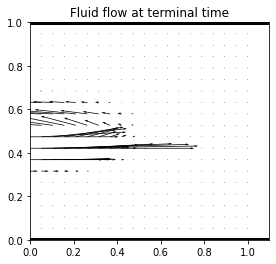

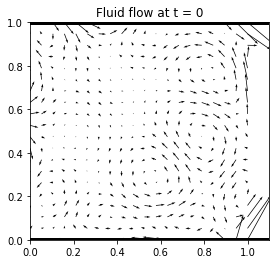

In [7]:
nu = 2
patches = 1
T = patches * .001
MAX_VAL = 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=10000,
    branch_nb_states_per_batch=1000,
    epochs=10000,
    fix_all_dim_except_first=False,
    fix_t_dim=True,
    overtrain_rate=0.,
    outlier_multiplier=10,
    continue_from_checkpoint="logs/20220530-162010-navier_stokes_2d_with_boundary-T1-nu0.2",
)
model.train_and_eval(debug_mode=False)
plot_fluid(model)

# Implementation with DGM

We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [ ]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [ ]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)